# Test 

In [5]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Bidirectional,LSTM,Input

In [3]:
T=8
D=2
M=3

In [4]:
X=np.random.randn(1,T,D)

## return_sequences=True

In [9]:
input_=Input(shape=(T,D))
rnn = Bidirectional(LSTM(M,return_state=True,return_sequences=True))
x=rnn(input_)

model=Model(input_,x)
o,h1,c1,h2,c2 = model.predict(X)

In [12]:
print("o:", o)
print("o.shape:", o.shape)
print("h1:", h1)
print("c1:", c1)
print("h2:", h2)
print("c2:", c2)

o: [[[ 0.06768235  0.06083761  0.08620139 -0.04819021 -0.05333244
   -0.07443325]
  [ 0.08645061  0.02856801  0.00742217 -0.23832723  0.18099368
    0.16010149]
  [ 0.05294225  0.01432441 -0.03160793 -0.18499178  0.14122875
    0.14832994]
  [ 0.02344614 -0.02548778 -0.06806743 -0.20717512  0.14662784
    0.15598397]
  [ 0.0072439  -0.08011875 -0.12178268 -0.18362091  0.10791086
    0.09498503]
  [ 0.0167401  -0.04882828 -0.11406979  0.04987476 -0.05499772
   -0.04004553]
  [-0.00492193 -0.02424675  0.03740595  0.04739095 -0.0616445
   -0.06243897]
  [-0.0070823  -0.03990755 -0.04962692 -0.09160414  0.07526714
    0.07915863]]]
o.shape: (1, 8, 6)
h1: [[-0.0070823  -0.03990755 -0.04962692]]
c1: [[-0.01407512 -0.08254969 -0.1179173 ]]
h2: [[-0.04819021 -0.05333244 -0.07443325]]
c2: [[-0.14686239 -0.10571471 -0.12190643]]


The **hidden state** should correspond to the **last output** since the output simply contains the hidden states at each time step.

$h_2$ is the final hidden state for the backwards LSTM. So if we're going from back to front, the final hidden state for the backwards LSTM should be at the front of the sequence. So if we look at the last three elements of the **first output** we see that this matches $h_2$.

## return_sequences=False

In [13]:
input_=Input(shape=(T,D))
rnn = Bidirectional(LSTM(M,return_state=True,return_sequences=False))
x=rnn(input_)

model=Model(input_,x)
o,h1,c1,h2,c2 = model.predict(X)

In [14]:
print("o:", o)
print("o.shape:", o.shape)
print("h1:", h1)
print("c1:", c1)
print("h2:", h2)
print("c2:", c2)

o: [[ 0.06681587  0.05622526  0.04715899 -0.13110313 -0.04053729  0.12135158]]
o.shape: (1, 6)
h1: [[0.06681587 0.05622526 0.04715899]]
c1: [[0.12279694 0.14017344 0.09119238]]
h2: [[-0.13110313 -0.04053729  0.12135158]]
c2: [[-0.21565707 -0.12700903  0.28103825]]


The **output** is just the concatenation of $h_1$ and $h_2$.

# Toxic comment classification with Bidirectional RNN

In [15]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM,Bidirectional,Dense, Input, GlobalMaxPooling1D, Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_auc_score

In [16]:
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 10

In [17]:
# load in pre-trained word vectors
word2vec = {}
with open("./large_files/glove.6B/glove.6B.{}d.txt".format(EMBEDDING_DIM)) as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.array(values[1:], dtype='float32')
        word2vec[word] = vec

In [18]:
# prepare text samples and their labels
train = pd.read_csv("./large_files/toxic/train.csv")
test = pd.read_csv("./large_files/toxic/test.csv")

In [19]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [20]:
sentences = train['comment_text'].fillna("dummy_value").values
sentences_test = test['comment_text'].fillna("dummy_value").values
possible_labels = ["toxic", "severe_toxic",
                   "obscene", "threat", "insult", "identity_hate"]
targets = train[possible_labels].values

In [21]:
# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

In [22]:
print("max sequence length:", max(len(s) for s in sequences))
print("min sequence length:", min(len(s) for s in sequences))
s = sorted(len(s) for s in sequences)
print("median sequence length:", s[len(s) // 2])
print("max word index:", max(max(seq) for seq in sequences if len(seq) > 0))

max sequence length: 1400
min sequence length: 0
median sequence length: 35
max word index: 19999


In [23]:
# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Found 210337 unique tokens.


In [24]:
# pad sequences so that we get a N x T matrix
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)
print('Shape of target tensor:', targets.shape)

Shape of data tensor: (159571, 100)
Shape of target tensor: (159571, 6)


In [25]:
# prepare embedding matrix
num_words = min(MAX_VOCAB_SIZE, len(word2idx)+1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, idx in word2idx.items():
    if idx < MAX_VOCAB_SIZE:
        embedding_vec = word2vec.get(word)
        if embedding_vec is not None:
            embedding_matrix[idx] = embedding_vec

In [26]:
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False
                            )

In [27]:
input_=Input(shape=(MAX_SEQUENCE_LENGTH,))
x=embedding_layer(input_)
x=Bidirectional(LSTM(15,return_sequences=True))(x)
x=GlobalMaxPooling1D()(x)
output=Dense(len(possible_labels),activation='sigmoid')(x)

In [28]:
model=Model(input_,output)
model.compile(loss='binary_crossentropy',
             optimizer=Adam(lr=0.01),
             metrics=['accuracy'])

In [29]:
model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 100)          2000000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100, 30)           13920     
_________________________________________________________________
global_max_pooling1d (Global (None, 30)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 186       
Total params: 2,014,106
Trainable params: 14,106
Non-trainable params: 2,000,000
_________________________________________________________________


In [30]:
r=model.fit(data,targets,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_split=VALIDATION_SPLIT)

Epoch 1/10
998/998 [==============================] - 20s 20ms/step - loss: 0.0659 - accuracy: 0.9897 - val_loss: 0.0559 - val_accuracy: 0.9898
Epoch 2/10
998/998 [==============================] - 19s 19ms/step - loss: 0.0523 - accuracy: 0.9788 - val_loss: 0.0540 - val_accuracy: 0.9543
Epoch 3/10
998/998 [==============================] - 19s 19ms/step - loss: 0.0491 - accuracy: 0.9629 - val_loss: 0.0514 - val_accuracy: 0.9821
Epoch 4/10
998/998 [==============================] - 19s 19ms/step - loss: 0.0476 - accuracy: 0.9634 - val_loss: 0.0516 - val_accuracy: 0.9324
Epoch 5/10
998/998 [==============================] - 19s 19ms/step - loss: 0.0464 - accuracy: 0.9656 - val_loss: 0.0510 - val_accuracy: 0.9623
Epoch 6/10
998/998 [==============================] - 19s 19ms/step - loss: 0.0460 - accuracy: 0.9619 - val_loss: 0.0513 - val_accuracy: 0.9548
Epoch 7/10
998/998 [==============================] - 19s 19ms/step - loss: 0.0450 - accuracy: 0.9639 - val_loss: 0.0513 - val_accuracy:

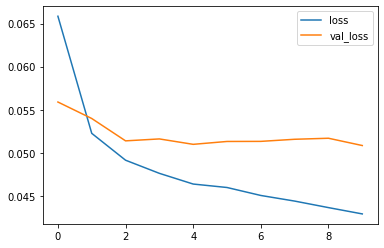

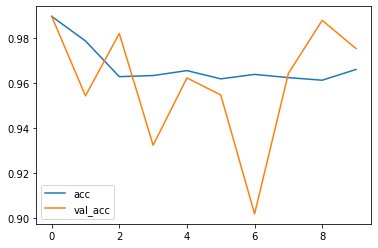

0.9852979934531333


In [31]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

p = model.predict(data)
aucs = []
for j in range(6):
    auc = roc_auc_score(targets[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))

# Image classification

In [59]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM,Lambda,Concatenate,Bidirectional,Dense, Input, GlobalMaxPooling1D, Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_auc_score
import tensorflow.keras.backend as K

In [160]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [161]:
x_train.shape, y_train.shape

((60000, 28, 28), (60000,))

In [162]:
D=28
M=15

In [163]:
# input is an image of size 28x28
input_=Input(shape=(D,D))

# up-down
rnn1=Bidirectional(LSTM(M,return_sequences = True))

x1= rnn1(input_)  # shape N x D x 2M

x1=GlobalMaxPooling1D()(x1) # shape N x 2M

# left-right
rnn2=Bidirectional(LSTM(M,return_sequences = True))

# custom layer
permutor = Lambda(lambda t:K.permute_dimensions(t,pattern=(0,2,1)))

In [164]:
x2=permutor(input_) # shape N x D x D
x2=rnn2(x2)  # shape N x D x 2M
x2=GlobalMaxPooling1D()(x2)  # shape N x 2M

# put them together
concatenator = Concatenate(axis = 1)
x=concatenator([x1,x2]) # output is N x 4M

# final dense layer
output = Dense(10,activation='softmax')(x) 

In [165]:
model=Model(input_,output)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer = 'adam',
              metrics=['accuracy'])

In [166]:
model.summary()

Model: "functional_53"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
lambda_10 (Lambda)              (None, 28, 28)       0           input_16[0][0]                   
__________________________________________________________________________________________________
bidirectional_23 (Bidirectional (None, 28, 30)       5280        input_16[0][0]                   
__________________________________________________________________________________________________
bidirectional_24 (Bidirectional (None, 28, 30)       5280        lambda_10[0][0]                  
______________________________________________________________________________________

In [168]:
r=model.fit(x_train,y_train,batch_size=32,epochs=10,validation_split=0.3)

Epoch 1/10
1313/1313 [==============================] - 7s 5ms/step - loss: 1.0499 - accuracy: 0.7076 - val_loss: 0.5131 - val_accuracy: 0.8687
Epoch 2/10
1313/1313 [==============================] - 6s 5ms/step - loss: 0.4043 - accuracy: 0.8904 - val_loss: 0.3269 - val_accuracy: 0.9071
Epoch 3/10
1313/1313 [==============================] - 6s 5ms/step - loss: 0.2876 - accuracy: 0.9165 - val_loss: 0.2666 - val_accuracy: 0.9208
Epoch 4/10
1313/1313 [==============================] - 6s 5ms/step - loss: 0.2384 - accuracy: 0.9300 - val_loss: 0.2223 - val_accuracy: 0.9346
Epoch 5/10
1313/1313 [==============================] - 6s 5ms/step - loss: 0.2048 - accuracy: 0.9392 - val_loss: 0.2023 - val_accuracy: 0.9378
Epoch 6/10
1313/1313 [==============================] - 6s 5ms/step - loss: 0.1870 - accuracy: 0.9426 - val_loss: 0.1877 - val_accuracy: 0.9434
Epoch 7/10
1313/1313 [==============================] - 6s 5ms/step - loss: 0.1776 - accuracy: 0.9456 - val_loss: 0.1844 - val_accuracy:

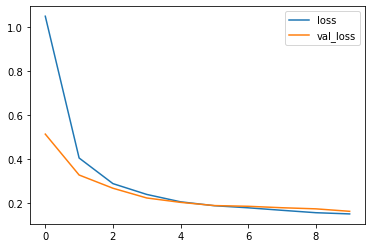

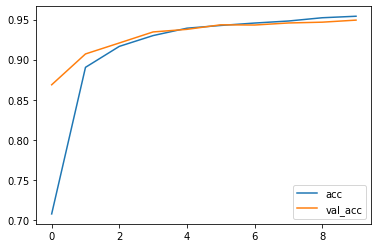

In [169]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()
